In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, RationalQuadratic, ExpSineSquared, Matern
import matplotlib.pyplot as plt
from scipy.stats import norm 

from collections import Counter
import math

# Adversarial environment

## First adversarial environment approach

The idea is to generate data each day from a different distributions among: linear, logit, probit, KERNEL

Dubt on the noise usage -> is it necessary? -> I'll proceed by using  noise_level=0 as default

In [2]:
class AdversarialPricingEnvironment:
    def __init__(self, max_price=1.0, models=['linear', 'logit', 'probit', 'KERNEL'], noise_level=0):
        self.max_price = max_price
        self.models = models
        self.noise_level = noise_level
        self.models_history = [] # to keep trace of the selection
        np.random.seed(42)

    def generate_data(self, n_points=100): # n_points: becomes the number of points generated each day (so the actions number)
        selected_model = np.random.choice(self.models)
        self.models_history.append(selected_model)
        
        prices = np.linspace(0, self.max_price, n_points)
        
        if selected_model == 'linear':
            beta_0 = 1  # Intercept
            beta_1 = -1  # Slope (-1/max_rpice)
            purchase_probabilities = beta_0 + beta_1 * prices
            
        elif selected_model == 'logit':
            alpha = 0
            beta = -5
            purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta * prices)))
            
        elif selected_model == 'probit':
            alpha = 0
            beta = -5
            purchase_probabilities = norm.cdf(alpha + beta * prices)

        elif selected_model == 'KERNEL':
            purchase_probabilities = np.abs(np.sin(2 * np.pi * prices) * np.exp(-prices * 5) + prices * .10) + .1

        
        # Noise
        noisy_purchase_probabilities = purchase_probabilities + np.random.normal(0, self.noise_level, n_points)
        
        # P is E [0, 1]
        noisy_purchase_probabilities = np.clip(noisy_purchase_probabilities, 0, 1)
        
        return prices.reshape(-1, 1), noisy_purchase_probabilities

## Second adversarial environment approach

Here we explore only the linear model where the intercept is fixed and the slope is sampled from a gaussian distribution with mean 1 and standard deviation 0.5

In [3]:
class AdversarialPricingEnvironment_Linear:
    def __init__(self, max_price=1.0, noise_level=0):
        self.max_price = max_price
        self.noise_level = noise_level
        np.random.seed(42)

    def generate_data(self, n_points=100): # Here n_points becomes the number of points generated each day         
        prices = np.linspace(0, self.max_price, n_points)
        
        alpha = 1
        beta = np.random.normal(1, 0.5) # original_beta = 1/max_price 
        purchase_probabilities = alpha - beta * prices
            
        # Noise
        noisy_purchase_probabilities = purchase_probabilities + np.random.normal(0, self.noise_level, n_points)
        
        # P is E [0, 1]
        noisy_purchase_probabilities = np.clip(noisy_purchase_probabilities, 0, 1)
        
        return prices.reshape(-1, 1), noisy_purchase_probabilities

# Agent

Here we'll work with the discretization of the prices interval 

**Comment:**  
Here we don't use directly the purchase probability as a reward, instead we derive:  
- the customers numer (customers_number_matrix[i, j] = np.random.binomial(n_customers, probabilities_matrix[i, j]))
- rewards (rewards_matrix[i, j] = customers_number_matrix[i, j]*(prices[j] - cost))  
- losses (max_reward = (max_price - cost) * n_customers  -->  loss_seq = max_reward - rewards_matrix) 

## EXP3

In [4]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

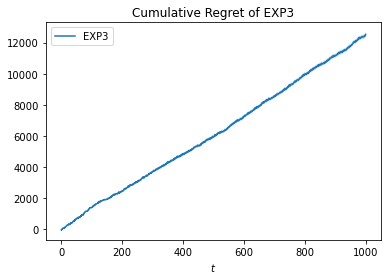

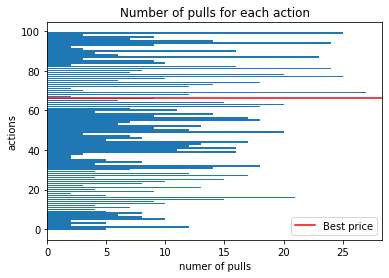

In [5]:
n_points = 100  # actions number
n_days = 1000 
cost = 0.2
n_customers = 200
max_price = 1.0

K = n_points
T = n_days

prices = np.linspace(0, max_price, n_points)

learning_rate = np.sqrt(np.log(K)/(K*T)) # we set the learning rate as prescribed by the theory (different from expert setting)

# Data generation -> each day the env samples for the prices of 'prices' the purchase probability, that is choosen randomly each day
env = AdversarialPricingEnvironment_Linear(max_price=1.0, noise_level=0)

prices_matrix = np.empty((n_days, n_points))  # Matrix to store prices for each day
probabilities_matrix = np.empty((n_days, n_points))  # Matrix to store purchase probabilities for each day
customers_number_matrix = np.empty((n_days, n_points))
rewards_matrix = np.empty((n_days, n_points))
loss_seq = np.empty((n_days, n_points))

for day in range(n_days):
    day_prices, day_probabilities = env.generate_data(n_points)
    prices_matrix[day] = day_prices[:, 0]  # Store only the first column (prices) of the generated prices for the day
    probabilities_matrix[day] = day_probabilities  # Store the generated probabilities for the day

# Probabilities_matrix -> customers_numbers -> rewards_matrix -> loss_seq
for i in range(n_days):
        for j in range(n_points):
            customers_number_matrix[i, j] = np.random.binomial(n_customers, probabilities_matrix[i, j])
            rewards_matrix[i, j] = customers_number_matrix[i, j]*(prices[j] - cost) # (Customers for that price (j) sampled in that day (i))*(that price(j) - cost)

max_reward = (max_price - cost) * n_customers
loss_seq = max_reward - rewards_matrix

best_arm_index = np.argmin(loss_seq.sum(axis=0))
best_arm = prices_matrix[0, best_arm_index]
clairvoyant_losses = loss_seq[:, best_arm_index]


n_trials = 100

exp3_regret_per_trial = []
# we keep the loss sequence fixed, we will only observe uncertainty due to algorithm's randomizations
for trial in range(n_trials):
    agent = EXP3Agent(K, learning_rate)
    
    expected_agent_losses = np.array([])
    for t in range(T):
        a_t = agent.pull_arm()
        l_t = loss_seq[t, a_t]
        agent.update(l_t)
        # logging
        expected_agent_losses = np.append(expected_agent_losses,
                                        np.dot(agent.x_t,
                                        loss_seq[t-1,:]))

    cumulative_regret = np.cumsum(expected_agent_losses-clairvoyant_losses)
    exp3_regret_per_trial.append(cumulative_regret)

exp3_regret_per_trial = np.array(exp3_regret_per_trial)

exp3_average_regret = exp3_regret_per_trial.mean(axis=0)
exp3_regret_sd = exp3_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), exp3_average_regret, label='EXP3')
plt.title('Cumulative Regret of EXP3')
plt.fill_between(np.arange(T),
                exp3_average_regret-exp3_regret_sd/np.sqrt(n_trials),
                exp3_average_regret+exp3_regret_sd/np.sqrt(n_trials),
                alpha=0.3)
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), agent.N_pulls)
plt.axhline(best_arm_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show()

## UCB1

In [6]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

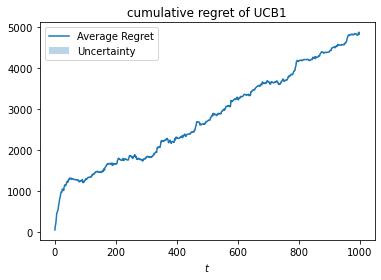

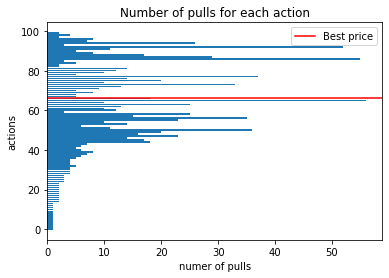

In [7]:
n_points = 100  # actions number
n_days = 1000 
cost = 0.2
n_customers = 200

max_price = 1

T = n_days 
K = n_points

prices = np.linspace(0, max_price, n_points)

# Data generation -> each day the env samples for the prices of 'prices' the purchase probability, that is choosen randomly each day
env = AdversarialPricingEnvironment_Linear(max_price=1.0, noise_level=0)

prices_matrix = np.empty((n_days, n_points))  # Matrix to store prices for each day
probabilities_matrix = np.empty((n_days, n_points))  # Matrix to store purchase probabilities for each day
customers_number_matrix = np.empty((n_days, n_points))
rewards_matrix = np.empty((n_days, n_points))

for day in range(n_days):
    day_prices, day_probabilities = env.generate_data(n_points)
    prices_matrix[day] = day_prices[:, 0]  # Store only the first column (prices) of the generated prices for the day
    probabilities_matrix[day] = day_probabilities  # Store the generated probabilities for the day

# Probabilities_matrix -> customers_numbers -> rewards_matrix
for i in range(n_days):
        for j in range(n_points):
            customers_number_matrix[i, j] = np.random.binomial(n_customers, probabilities_matrix[i, j])
            rewards_matrix[i, j] = customers_number_matrix[i, j]*(prices[j] - cost) # (Customers for that price (j) sampled in that day (i))*(that price(j) - cost)


best_arm_index = np.argmax(rewards_matrix.sum(axis=0))
best_arm = prices[best_arm_index]
clairvoyant_rewards = rewards_matrix[:, best_arm_index]

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    ucb_agent = UCB1Agent(K, T, range=15)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        r_t = rewards_matrix[t, pi_t]
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_arm_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

**Comment:**  
If we set the parameter 'range' equal to 1 for the UCB1 agent, he doesn't explore, we have to increase it in order to insert more optimism and incentivize the exploration.  
Notice that this operation will reduce the exploitation weight, so we'll have to set 'range' finding the correct trade-off between exploration and explotation.  
(Here range = 15 is not that bad).  
  
Notice that this holds for the not noisy case, if we insert the noise the algorithm needs 'range' bigger to achive same results.